# Clustering - Tuto 1

In [70]:
# Libraries import section

import os

import xarray as xr
import numpy as np
from scipy import stats

from sklearn import preprocessing
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

import matplotlib
# matplotlib.use('agg')
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.cm as cm
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
sns.set(context="notebook", style="whitegrid", palette="deep", color_codes=True)

In [2]:
# Define usefull functions

def create_map(extent=[-180, 180, -70, 70]):
    fig = plt.figure(figsize=(12,4),dpi=200)
    proj = ccrs.PlateCarree()
    ax = fig.add_axes([0,0,1,1],projection=proj)
    ax.set_extent(extent, crs=proj)
    gl=ax.gridlines(crs=proj, draw_labels=True,
        linewidth=0.5, color=[0.6]*3, alpha=0.5, linestyle='--')
    # gl.xlocator = mticker.FixedLocator(np.linspace(-180,180,360/10+1))
    # gl.ylocator = mticker.FixedLocator(np.linspace(-90,90,180/5+1))
    gl.xlocator = mticker.FixedLocator(np.linspace(-180,180,360/30+1))
    gl.ylocator = mticker.FixedLocator(np.linspace(-90,90,180/20+1))
    gl.xlabels_top = False
    gl.ylabels_right = False
    ax.add_feature(cfeature.LAND, facecolor=[0.7]*3)
    ax.add_feature(cfeature.COASTLINE)
    return fig, proj, ax

# Load data

In [7]:
# https://storage.cloud.google.com/sonific01/ARGO/GLOB_HOMOGENEOUS_variables_3subset_3.nc?_ga=2.221604568.-1386953781.1538471925

# Define where to find the Argo file on disk:
ncroot = '/home1/datahome/gmaze/datawork/data/ARGO/copoda_db/global'
ncfile = 'GLOB_HOMOGENEOUS_variables_3subset_1.nc'
#ncfile = 'GLOB_HOMOGENEOUS_variables_3subset_*.nc'

# Load Argo SDL data:
ds = xarray.open_dataset(os.path.join(ncroot,ncfile),chunks={'N_PROF':16000})
print ds

<xarray.Dataset>
Dimensions:    (DEPTH: 302, N_PROF: 67010)
Coordinates:
  * DEPTH      (DEPTH) float32 0.0 -5.0 -10.0 -15.0 ... -1495.0 -1500.0 -1505.0
Dimensions without coordinates: N_PROF
Data variables:
    LATITUDE   (N_PROF) float32 dask.array<shape=(67010,), chunksize=(16000,)>
    LONGITUDE  (N_PROF) float32 dask.array<shape=(67010,), chunksize=(16000,)>
    TIME       (N_PROF) datetime64[ns] dask.array<shape=(67010,), chunksize=(16000,)>
    DBINDEX    (N_PROF) float64 dask.array<shape=(67010,), chunksize=(16000,)>
    TEMP       (N_PROF, DEPTH) float32 dask.array<shape=(67010, 302), chunksize=(16000, 302)>
    PSAL       (N_PROF, DEPTH) float32 dask.array<shape=(67010, 302), chunksize=(16000, 302)>
    SIG0       (N_PROF, DEPTH) float32 dask.array<shape=(67010, 302), chunksize=(16000, 302)>
    BRV2       (N_PROF, DEPTH) float32 dask.array<shape=(67010, 302), chunksize=(16000, 302)>
Attributes:
    Title:             VENTHSAL-IA
    long_title:        Argo subset of plain pr

# Stats for 1D data

In [102]:
z = -250
X, Xlabel = ds.TEMP.sel(DEPTH=z,method='nearest'), "TEMP@%0.2fm"%(X['DEPTH'])
# X, Xlabel = ds.TEMP.mean(dim='DEPTH'), "VERTICAL MEAN TEMP"
print Xlabel

TEMP@-250.00m


Text(0.5,1,'TEMP@-250.00m')

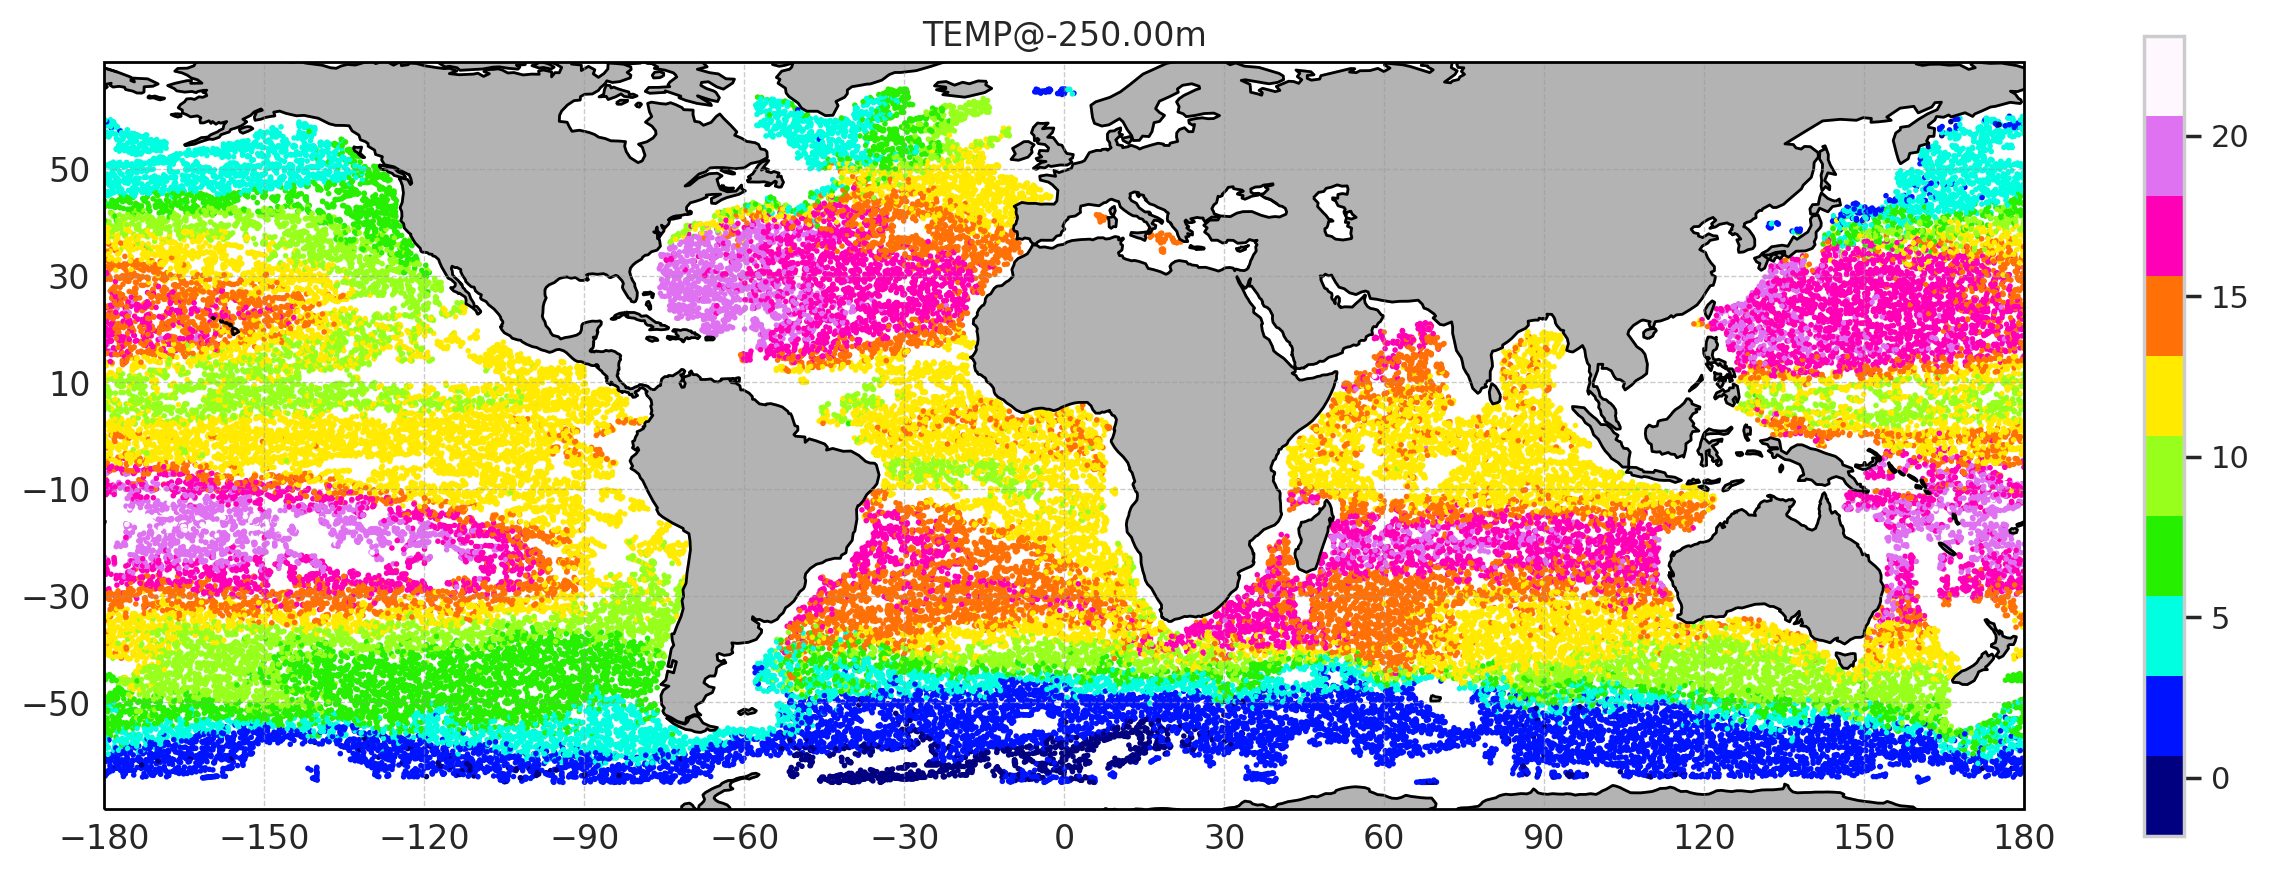

In [105]:
fig, proj, ax = create_map()
plt.scatter(ds.LONGITUDE,ds.LATITUDE,1,X,cmap=plt.cm.get_cmap('gist_ncar',10))
plt.colorbar()
plt.title(Xlabel)

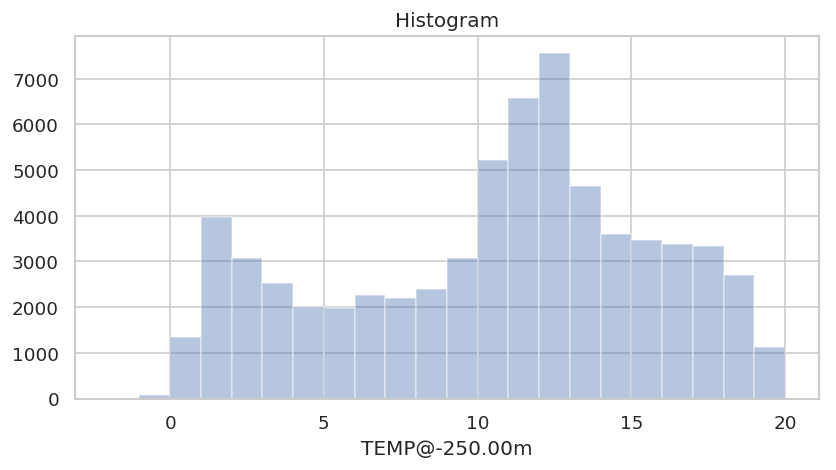

In [104]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=plt.figaspect(0.5), dpi=120)
axes.set_title('Histogram')
sns.distplot(X, bins=np.linspace(-2.,20.,22+1), kde=False, axlabel=Xlabel)
# n, bins, patches = plt.hist(x, bins=np.linspace(-2.,20.,22+1))

In [94]:
# From xarray, X has shape: (67010,)
# For scikitlearn we need X with shape: [67010,1]
X0 = X.values[np.newaxis].T
print "Data shape [n_samples, n_features]:", X0.shape # shape [n_samples, n_features=1]

# Fit the scaler object:
scaler = preprocessing.StandardScaler()
scaler = scaler.fit(X0)

# The mean and std profiles are in the scaler object properties:
X_ave = scaler.mean_
X_std = scaler.scale_
print "Data mean, std:", X_ave, X_std

# Normalize data:
Xn = scaler.transform(X0)       

# Here, we only center data:
Xc = preprocessing.StandardScaler(with_std=False).fit(X0).transform(X0)

Data shape [n_samples, n_feature]: (67010, 1)
Data mean,std: [10.64183611] [5.16234012]


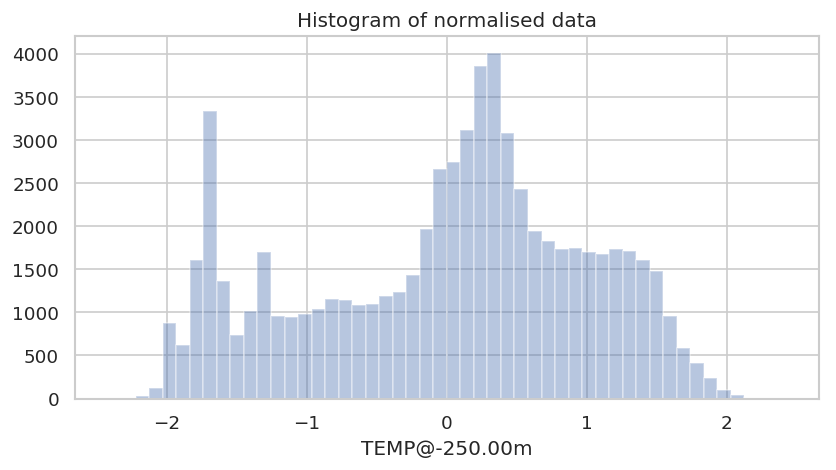

In [100]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=plt.figaspect(0.5), dpi=120)
axes.set_title('Histogram of normalised data')
sns.distplot(Xn, kde=False, axlabel=Xlabel)

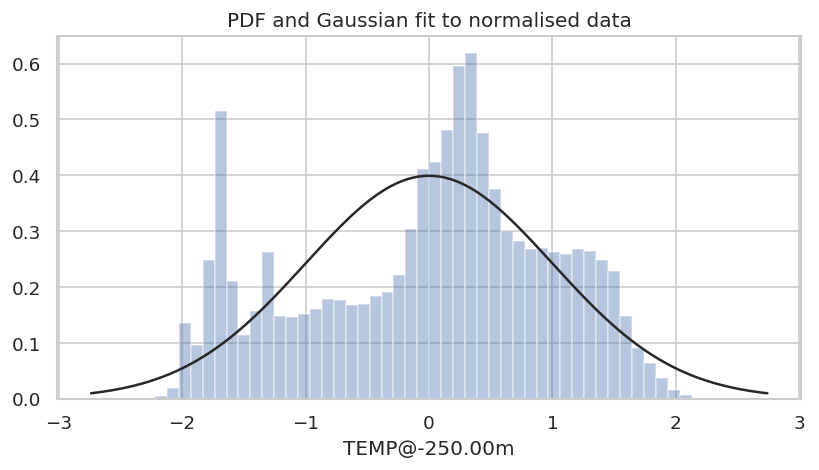

In [107]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=plt.figaspect(0.5), dpi=120)
axes.set_title('PDF and Gaussian fit to normalised data')
sns.distplot(Xn, kde=False, fit=stats.norm, axlabel=Xlabel)

# Clustering in 1D

Clearly from the figure above, one can see that the dataset is not Gaussian and exhibits several modes. In other words, data samples agregated into several clusters.

Let's identify them